# MNIST dataset

The Notebook is split in three parts:
* Data Preparation
* Model Building
* Evaluation

## Data Preparation

In [1]:
# libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import StratifiedShuffleSplit
from keras.preprocessing.image import ImageDataGenerator
%matplotlib inline

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
C:\Users\gwehrm\AppData\Roaming\Python\Python36\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\gwehrm\AppData\Roaming\Python\Python36\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\gwehrm\AppData\Roaming\P

In [2]:
# load the data
train = pd.read_csv("./Data/train.csv")
test  = pd.read_csv("./Data/test.csv")

In [3]:
display(train.shape)
display(test.shape)
# 42000 different training observations with 784 pixel values and label in the first column
# the pixel valies need to be rearranged to 28*28

(42000, 785)

(28000, 784)

In [4]:
# label
y_train = train["label"]

# predictors
x_train = train.drop(columns = 'label')
x_test = test
# del old df
del train

In training the NN, scaling data is important. The pixel intensities of images are in the range of [0, 255], which makes the neural network difficult to learn.

In [5]:
x_train = x_train/255
x_test = x_test/255

In [6]:
x_train = x_train.values.reshape(42000,28,28,1)
x_test = test.values.reshape(28000,28,28,1)
display(x_train.shape)

(42000, 28, 28, 1)

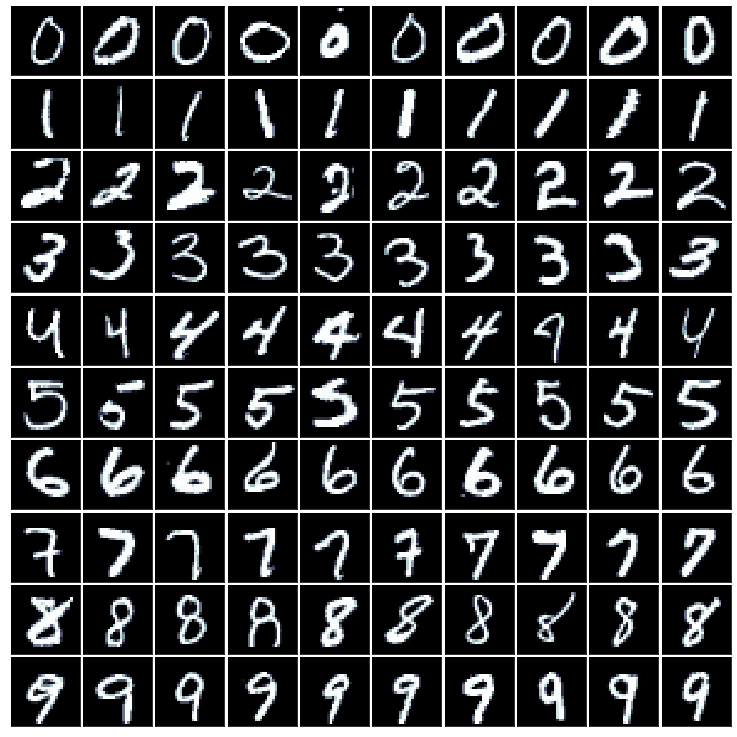

In [7]:
# show some random digits for each label

def display_images(images, shape):
    fig = plt.figure(figsize=shape)
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)
    for i in range(np.prod(shape)):
        p = fig.add_subplot(shape[0], shape[1], i+1, xticks=[], yticks=[])
        p.imshow(images[i], cmap=plt.cm.bone)           
        
        
# get unique labels
unique_labels = np.unique(y_train)

# get the index/label for them
images = []
for l in unique_labels:    
    idx = np.where(y_train == l)[0]
    idx = idx[np.random.permutation(len(idx))[:10]] 
    for i in idx:
        images += [x_train[i].reshape(28,28)]

display_images(images,shape=(10, 10))

In [8]:
# the labels are integers - therefore, the keras function to_categorical can be used to encode it
from keras.utils import to_categorical

# transformation:
def ohe(labs):
    ohe_labs = to_categorical(labs)
    return ohe_labs
y_train = ohe(y_train)

In [9]:
# prepare for splitting 0.3 - split the train data in another train and validation set
ss = StratifiedShuffleSplit(n_splits=1, test_size=.3, random_state=1)

#split and get train/val
ss.get_n_splits(x_train, y_train)
for train_index, val_index in ss.split(x_train, y_train):
    x_train, x_val = x_train[train_index], x_train[val_index]
    y_train, y_val = y_train[train_index], y_train[val_index]
    print(len(y_train),len(y_val))

29400 12600


## Model Building

In [10]:
# Import the necessary components from Keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPool2D, BatchNormalization

# Initialize the model object
model = Sequential()

# # Add a convolutional layer
# model.add(Conv2D(20, kernel_size=3, activation='relu', 
#                input_shape=(28,28,1),
#                 padding = "same"))

# model.add(Dropout(0.1))

# model.add(Conv2D(15, kernel_size=6, activation='relu'))

# model.add(Dropout(0.1))

# model.add(Conv2D(10, kernel_size=9, activation='relu'))

# # model.add(Conv2D(10, kernel_size=12, activation='relu'))

# model.add(Conv2D(32,kernel_size=5,activation='relu',input_shape=(28,28,1)))
# model.add(Dropout(0.4))
# model.add(MaxPool2D())
# model.add(Conv2D(64,kernel_size=5,activation='relu'))
# model.add(Dropout(0.4))
# model.add(MaxPool2D())
# model.add(Flatten())
# model.add(Dense(512, activation='relu'))
# model.add(Dense(10, activation='softmax'))




model.add(Conv2D(32,kernel_size=3,activation='relu',input_shape=(28,28,1)))
model.add(BatchNormalization())
model.add(Conv2D(32,kernel_size=3,activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(32,kernel_size=5,strides=2,padding='same',activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.4))

model.add(Conv2D(64,kernel_size=3,activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(64,kernel_size=3,activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(64,kernel_size=5,strides=2,padding='same',activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.4))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.4))
model.add(Dense(10, activation='softmax'))

To increase the process, keras allows to modify the learning rate:
    

In [13]:
from keras.callbacks import LearningRateScheduler

In [20]:
# Compile the model 
model.compile(optimizer="Adamax", 
              loss="categorical_crossentropy", 
              metrics=["accuracy"])

annealer = LearningRateScheduler(lambda x: 1e-3 * 0.9 ** x)

## Data Augmentation:

In [15]:
datagen = ImageDataGenerator(
        rotation_range=10,  
        zoom_range = 0.10,  
        width_shift_range=0.1, 
        height_shift_range=0.1)

In [21]:
hist = model.fit_generator(datagen.flow(x_train, y_train, batch_size=16),
                           steps_per_epoch=500,
                           epochs=45, 
                           verbose=2,  #1 for ETA, 0 for silent
                           validation_data=(x_val[:400,:], y_val[:400,:]), #For speed
                           callbacks=[annealer])

Epoch 1/45
 - 67s - loss: 0.1054 - accuracy: 0.9686 - val_loss: 0.0316 - val_accuracy: 0.9900
Epoch 2/45
 - 59s - loss: 0.0932 - accuracy: 0.9729 - val_loss: 0.0304 - val_accuracy: 0.9875
Epoch 3/45
 - 67s - loss: 0.0748 - accuracy: 0.9770 - val_loss: 0.0234 - val_accuracy: 0.9900
Epoch 4/45
 - 69s - loss: 0.0874 - accuracy: 0.9761 - val_loss: 0.0258 - val_accuracy: 0.9900
Epoch 5/45
 - 59s - loss: 0.0721 - accuracy: 0.9785 - val_loss: 0.0277 - val_accuracy: 0.9925
Epoch 6/45
 - 65s - loss: 0.0655 - accuracy: 0.9795 - val_loss: 0.0201 - val_accuracy: 0.9875
Epoch 7/45
 - 66s - loss: 0.0677 - accuracy: 0.9808 - val_loss: 0.0217 - val_accuracy: 0.9925
Epoch 8/45
 - 57s - loss: 0.0665 - accuracy: 0.9808 - val_loss: 0.0236 - val_accuracy: 0.9925
Epoch 9/45
 - 54s - loss: 0.0644 - accuracy: 0.9809 - val_loss: 0.0244 - val_accuracy: 0.9900
Epoch 10/45
 - 52s - loss: 0.0646 - accuracy: 0.9807 - val_loss: 0.0165 - val_accuracy: 0.9925
Epoch 11/45
 - 49s - loss: 0.0575 - accuracy: 0.9820 - val_

In [22]:
# evaluate the model:
model.evaluate(x_val,y_val)

12600/12600 [==============================] - 21s 2ms/step


[0.01762297594504956, 0.9946825504302979]

In [ ]:
# the model reached an accuracy of 99.29% 

In [18]:
model.evaluate(x_val,y_val)

12600/12600 [==============================] - 20s 2ms/step


[0.02383978288306574, 0.9929364919662476]

# Submission

In [23]:
# predict results
results = model.predict(x_test)

# select the indix with the maximum probability
results = np.argmax(results,axis = 1)

results = pd.Series(results,name="Label")

In [24]:
submission = pd.concat([pd.Series(range(1,28001),name = "ImageId"),results],axis = 1)

submission.to_csv("pred_mnist.csv",index=False)